In [1]:
#Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter('ignore')

#Import the module for the logistic regression model
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import statsmodels.api as sm
import scipy.stats as stats

pd.set_option('display.max_columns', None)
plt.style.use('bmh')
sns.set()

In [2]:
# Import the library (use .formula so we can write the formula we want in the model)
import statsmodels.formula.api as smf

In [3]:
df = pd.read_csv("D:\PACMANN AI\Data kaggle\honda_sell_data.csv")

In [4]:
df.head()

,Year,Make,Model,Condition,Price,Consumer_Rating,Consumer_Review_#,Exterior_Color,Interior_Color,Drivetrain,MPG,Fuel_Type,Transmission,Engine,VIN,Stock_#,Mileage,Comfort_Rating,Interior_Design_Rating,Performance_Rating,Value_For_Money_Rating,Exterior_Styling_Rating,Reliability_Rating,State,Seller_Type
0,2023,Honda,Ridgeline RTL,New,"$46,370",4.8,9,Platinum White Pearl,Beige,All-wheel Drive,NaN,Gasoline,Automatic,3.5L V6 24V GDI SOHC,5FPYK3F58PB011817,00830164,10,5.0,4.8,4.8,4.2,5.0,5.0,CA,Dealer
1,2023,Honda,CR-V Hybrid Sport,New,"$34,150",1.7,24,Platinum White Pearl,Black,FWD,NaN,Hybrid,Automatic CVT,2.0L I4 16V GDI DOHC Hybrid,2HKRS5H5XPH702953,6402953,–,5.0,3.0,4.0,4.0,5.0,5.0,CA,Dealer
2,2023,Honda,CR-V Hybrid Sport,New,"$34,245",4.7,2869,Meteorite Gray Metallic,Black,Front-wheel Drive,NaN,Hybrid,Automatic CVT,2.0L I4 16V GDI DOHC Hybrid,2HKRS5H55PH704805,PH704805,1,5.0,3.0,4.0,4.0,5.0,5.0,CA,Dealer
3,2022,Honda,Pilot TrailSport,New,"$46,500",5.0,12,Sonic Gray Pearl,Black,All-wheel Drive,19–25,Gasoline,9-Speed Automatic,3.5L V6 24V GDI SOHC,5FNYF6H82NB100429,5700429B,5,5.0,5.0,5.0,5.0,5.0,5.0,CA,Dealer
4,2023,Honda,CR-V Hybrid Sport Touring,New,"$40,395",4.4,12,Crystal Black Pearl,Black,All-wheel Drive,NaN,Hybrid,Automatic CVT,2.0L I4 16V GDI DOHC Hybrid,2HKRS6H90PH805954,5705954,5,5.0,3.0,4.0,4.0,5.0,5.0,CA,Dealer


# Data Cleaning

In [5]:
#Replace '-' into NaN
cols = ['Year','Make','Model','Condition','Price','Consumer_Rating','Consumer_Review_#','Exterior_Color','Interior_Color','Drivetrain','MPG','Fuel_Type','Transmission','Engine','VIN','Stock_#','Mileage','Comfort_Rating','Interior_Design_Rating','Performance_Rating','Value_For_Money_Rating','Exterior_Styling_Rating','Reliability_Rating', 'State', 'Seller_Type']
df[cols] = df[cols].replace({"–": np.nan})

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4999 entries, 0 to 4998
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Year                     4999 non-null   int64  
 1   Make                     4999 non-null   object 
 2   Model                    4999 non-null   object 
 3   Condition                4999 non-null   object 
 4   Price                    4999 non-null   object 
 5   Consumer_Rating          4999 non-null   float64
 6   Consumer_Review_#        4999 non-null   int64  
 7   Exterior_Color           4892 non-null   object 
 8   Interior_Color           4278 non-null   object 
 9   Drivetrain               4983 non-null   object 
 10  MPG                      3514 non-null   object 
 11  Fuel_Type                4988 non-null   object 
 12  Transmission             4962 non-null   object 
 13  Engine                   4988 non-null   object 
 14  VIN                     

In [7]:
# Price to int
# Mileago to float
df["Price"] = df["Price"].str.replace("$", "", regex=False).str.replace(",", "", regex=False).str.replace("Not Priced", "0", regex=False).astype(float)
df["Price"] = df["Price"].replace(0.0, np.nan, regex=False)
df["Mileage"] = df["Mileage"].str.replace("USB", "100.1234", regex=False).str.replace("Premium", "100.1234", regex=False).str.replace("HomeLinkRear", "100.1234", regex=False).str.replace("Alloy", "100.1234", regex=False).str.replace("Bluetooth100.1234", "100.1234", regex=False).str.replace("Apple", "100.1234", regex=False).astype(float)
df["Mileage"] = df["Mileage"].replace(100.1234, np.nan, regex=False)

In [8]:
# Replaces the null values from Prices with it's models average
def average_price():
    average_price_per_model = df.groupby("Model")[["Price"]].agg(np.mean)
    null_prices_rows = df[df["Price"].isna()][["Model","Price"]]
    for index in list(null_prices_rows.index):
        model = null_prices_rows.loc[[index]]['Model'].item()
        df.at[index,'Price'] = average_price_per_model.loc[[model]]['Price'].item()
average_price()

In [9]:
# Replaces the null values from Ratings with it's models median ratings
def median_ratings():
    for rating_type in ['Comfort_Rating','Interior_Design_Rating','Performance_Rating','Value_For_Money_Rating','Exterior_Styling_Rating','Reliability_Rating']:
        average_rating_type_car_model = df[[rating_type,"Model"]].groupby("Model").agg(np.median)
        null_rating_type_rows = df[df[rating_type].isna()][["Model",rating_type]]
        for index in list(null_rating_type_rows.index):
            model = null_rating_type_rows.loc[[index]]['Model'].item()
            df.at[index,rating_type] = average_rating_type_car_model.loc[[model]][rating_type].item()
median_ratings()

In [10]:
# Replaces the null values from MPG with it's models average
def averageMPG():
    for mpg in ['min_MPG','max_MPG','avg_MPG']:
        average_mpg_car_model = df1[[mpg,"Model"]].groupby("Model").agg(np.mean)
        null_mpg_rows = df1[df1[mpg].isna()][["Model",mpg]]
        for index in list(null_mpg_rows.index):
            model = null_mpg_rows.loc[[index]]['Model'].item()
            df1.at[index,mpg] = average_mpg_car_model.loc[[model]][mpg].item()

In [11]:
df.isna().sum()

Year                          0
Make                          0
Model                         0
Condition                     0
Price                         0
Consumer_Rating               0
Consumer_Review_#             0
Exterior_Color              107
Interior_Color              721
Drivetrain                   16
MPG                        1485
Fuel_Type                    11
Transmission                 37
Engine                       11
VIN                          11
Stock_#                      11
Mileage                     298
Comfort_Rating               67
Interior_Design_Rating       67
Performance_Rating           67
Value_For_Money_Rating       67
Exterior_Styling_Rating      67
Reliability_Rating           67
State                        73
Seller_Type                  73
dtype: int64

In [12]:
df1 = df.dropna(subset=['Comfort_Rating','State','Seller_Type','Transmission','Exterior_Color','Drivetrain','Mileage']).drop(['Interior_Color'], axis=1).drop_duplicates()

df1['min_MPG'] = df1['MPG'].str.split("–",expand = True)[0]
df1['max_MPG'] = df1['MPG'].str.split("–",expand = True)[1]
df1.drop(['MPG'], axis=1, inplace=True)

df1[['min_MPG', 'max_MPG']] = df1[['min_MPG', 'max_MPG']].fillna(0)
df1['min_MPG'] = df1['min_MPG'].astype(float)
df1['max_MPG'] = df1['max_MPG'].astype(float)
df1['avg_MPG'] = (df1['min_MPG']+df1['max_MPG'])/2
df1[['min_MPG', 'max_MPG', 'avg_MPG']] = df1[['min_MPG', 'max_MPG', 'avg_MPG']].replace(0.0, np.nan)

averageMPG()

df1.dropna(subset=['min_MPG','max_MPG','avg_MPG'], inplace=True)
df1.drop(df1[(df1['State']=='MO-22') | (df1['State']=='Route') | (df1['State']=='Glens')].index, inplace=True)

df1['Transmission'] = df1['Transmission'].str.lower()
df1.loc[df1['Transmission'].str.contains('automatic|a/t|9-speed', regex=True), 'Transmission'] = 'automatic'
df1.loc[df1['Transmission'].str.contains('manual|m/t', regex=True), 'Transmission'] = 'manual'
df1.loc[df1['Transmission'].str.contains('cvt|variable|driver selectable mode', regex=True), 'Transmission'] = 'cvt'
df1.loc[(df1['Transmission'].str.contains('other')) & (df1['Model'].str.contains('CR-V')), 'Transmission'] = 'cvt'
df1.loc[(df1['Transmission'].str.contains('other')), 'Transmission'] = 'automatic'

df1['Drivetrain'] = df1['Drivetrain'].str.lower()
df1.loc[df1['Drivetrain'].str.contains('front-wheel drive|fwd', regex=True), 'Drivetrain'] = 'fwd'
df1.loc[df1['Drivetrain'].str.contains('all-wheel drive|awd|four-wheel drive', regex=True), 'Drivetrain'] = 'awd'
df1.loc[df1['Drivetrain'].str.contains('rear-wheel drive', regex=True), 'Drivetrain'] = 'rwd'

print(df1.shape)
df1.isna().sum()

(4426, 26)


Year                       0
Make                       0
Model                      0
Condition                  0
Price                      0
Consumer_Rating            0
Consumer_Review_#          0
Exterior_Color             0
Drivetrain                 0
Fuel_Type                  0
Transmission               0
Engine                     0
VIN                        0
Stock_#                    0
Mileage                    0
Comfort_Rating             0
Interior_Design_Rating     0
Performance_Rating         0
Value_For_Money_Rating     0
Exterior_Styling_Rating    0
Reliability_Rating         0
State                      0
Seller_Type                0
min_MPG                    0
max_MPG                    0
avg_MPG                    0
dtype: int64

In [13]:
df.head()

,Year,Make,Model,Condition,Price,Consumer_Rating,Consumer_Review_#,Exterior_Color,Interior_Color,Drivetrain,MPG,Fuel_Type,Transmission,Engine,VIN,Stock_#,Mileage,Comfort_Rating,Interior_Design_Rating,Performance_Rating,Value_For_Money_Rating,Exterior_Styling_Rating,Reliability_Rating,State,Seller_Type
0,2023,Honda,Ridgeline RTL,New,46370.0,4.8,9,Platinum White Pearl,Beige,All-wheel Drive,NaN,Gasoline,Automatic,3.5L V6 24V GDI SOHC,5FPYK3F58PB011817,00830164,10.0,5.0,4.8,4.8,4.2,5.0,5.0,CA,Dealer
1,2023,Honda,CR-V Hybrid Sport,New,34150.0,1.7,24,Platinum White Pearl,Black,FWD,NaN,Hybrid,Automatic CVT,2.0L I4 16V GDI DOHC Hybrid,2HKRS5H5XPH702953,6402953,NaN,5.0,3.0,4.0,4.0,5.0,5.0,CA,Dealer
2,2023,Honda,CR-V Hybrid Sport,New,34245.0,4.7,2869,Meteorite Gray Metallic,Black,Front-wheel Drive,NaN,Hybrid,Automatic CVT,2.0L I4 16V GDI DOHC Hybrid,2HKRS5H55PH704805,PH704805,1.0,5.0,3.0,4.0,4.0,5.0,5.0,CA,Dealer
3,2022,Honda,Pilot TrailSport,New,46500.0,5.0,12,Sonic Gray Pearl,Black,All-wheel Drive,19–25,Gasoline,9-Speed Automatic,3.5L V6 24V GDI SOHC,5FNYF6H82NB100429,5700429B,5.0,5.0,5.0,5.0,5.0,5.0,5.0,CA,Dealer
4,2023,Honda,CR-V Hybrid Sport Touring,New,40395.0,4.4,12,Crystal Black Pearl,Black,All-wheel Drive,NaN,Hybrid,Automatic CVT,2.0L I4 16V GDI DOHC Hybrid,2HKRS6H90PH805954,5705954,5.0,5.0,3.0,4.0,4.0,5.0,5.0,CA,Dealer


In [14]:
df1.head()

,Year,Make,Model,Condition,Price,Consumer_Rating,Consumer_Review_#,Exterior_Color,Drivetrain,Fuel_Type,Transmission,Engine,VIN,Stock_#,Mileage,Comfort_Rating,Interior_Design_Rating,Performance_Rating,Value_For_Money_Rating,Exterior_Styling_Rating,Reliability_Rating,State,Seller_Type,min_MPG,max_MPG,avg_MPG
0,2023,Honda,Ridgeline RTL,New,46370.0,4.8,9,Platinum White Pearl,awd,Gasoline,automatic,3.5L V6 24V GDI SOHC,5FPYK3F58PB011817,00830164,10.0,5.0,4.8,4.8,4.2,5.0,5.0,CA,Dealer,17.825000,24.075000,20.950000
2,2023,Honda,CR-V Hybrid Sport,New,34245.0,4.7,2869,Meteorite Gray Metallic,fwd,Hybrid,automatic,2.0L I4 16V GDI DOHC Hybrid,2HKRS5H55PH704805,PH704805,1.0,5.0,3.0,4.0,4.0,5.0,5.0,CA,Dealer,41.800000,35.200000,38.500000
3,2022,Honda,Pilot TrailSport,New,46500.0,5.0,12,Sonic Gray Pearl,awd,Gasoline,automatic,3.5L V6 24V GDI SOHC,5FNYF6H82NB100429,5700429B,5.0,5.0,5.0,5.0,5.0,5.0,5.0,CA,Dealer,19.000000,25.000000,22.000000
4,2023,Honda,CR-V Hybrid Sport Touring,New,40395.0,4.4,12,Crystal Black Pearl,awd,Hybrid,automatic,2.0L I4 16V GDI DOHC Hybrid,2HKRS6H90PH805954,5705954,5.0,5.0,3.0,4.0,4.0,5.0,5.0,CA,Dealer,40.000000,34.000000,37.000000
5,2023,Honda,Odyssey EX-L,New,42250.0,4.4,12,Pacific Pewter Metallic,fwd,Gasoline,automatic,3.5L V6 24V GDI SOHC,5FNRL6H67PB024270,5724270,5.0,5.0,5.0,4.0,4.0,4.0,5.0,CA,Dealer,18.932203,27.805085,23.368644


# EDA

In [17]:
col = ['Price', 'Consumer_Rating', 'Consumer_Review_#', 'Mileage', 'Comfort_Rating', 'Interior_Design_Rating', 'Performance_Rating', 
      'Value_For_Money_Rating', 'Exterior_Styling_Rating', 'Reliability_Rating', 'avg_MPG']

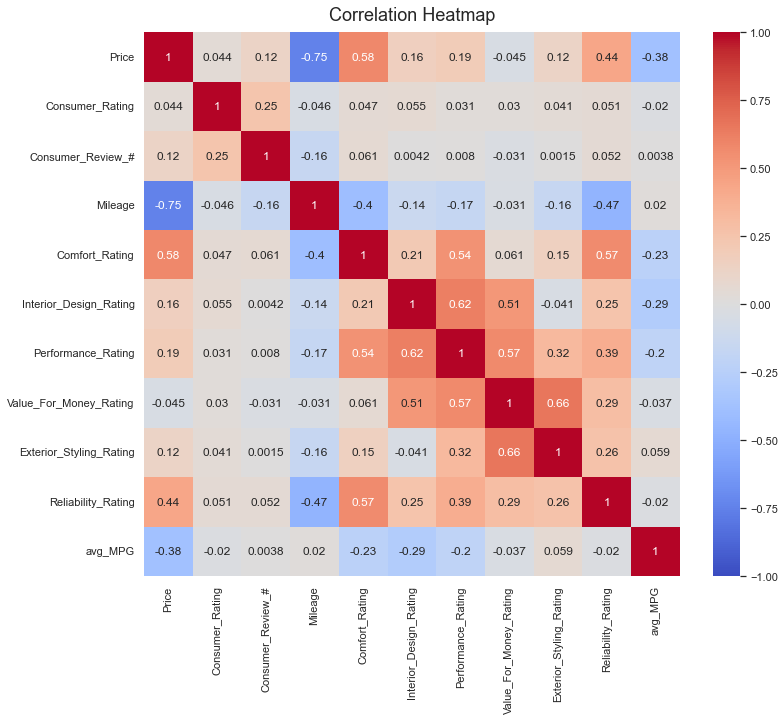

In [39]:
plt.figure(figsize=(12, 10))

heatmap = sns.heatmap(df1[col].corr(), vmin=-1, vmax=1, annot=True, cmap='coolwarm')

heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);

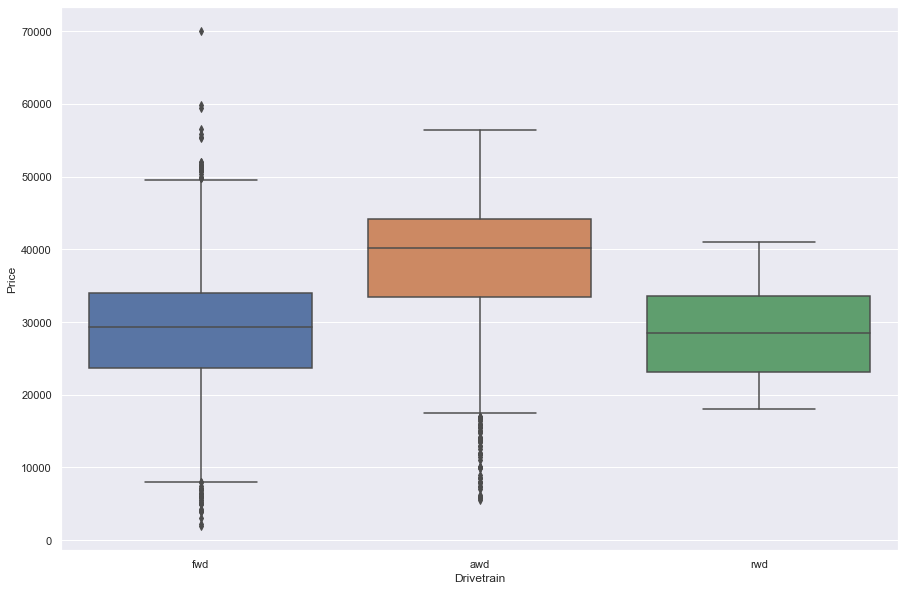

In [25]:
plt.figure(figsize=(15,10))
sns.boxplot(data=df1.sort_values('Price'), x="Drivetrain", y="Price");

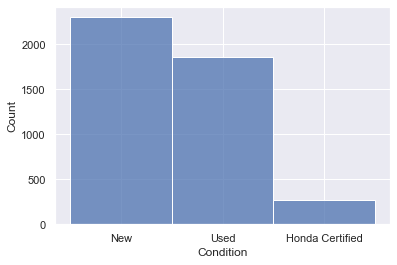

In [26]:
sns.histplot(data=df1, x="Condition");

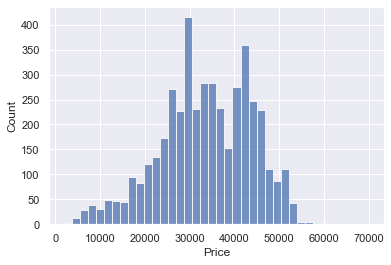

In [27]:
sns.histplot(data=df1, x="Price");

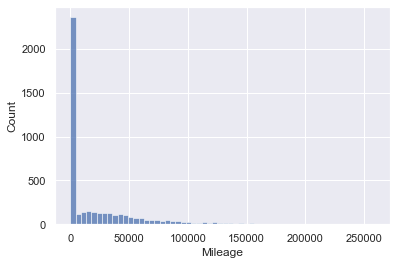

In [28]:
sns.histplot(data=df1, x="Mileage");

# Statistical Test

In [29]:
# Shapiro-Wilk test for normality
stat, p = stats.shapiro(df1['Price'])
alpha = 0.05
if p > alpha:
    print("Price data is normally distributed (fail to reject H0)")
else:
    print("Price data is not normally distributed (reject H0)")
    
# Pearson correlation coefficient
corr_coef, p_value = stats.pearsonr(df1['Price'], df1['Mileage'])
print("Pearson correlation coefficient between Price and Mileage: ", corr_coef)
if p_value < alpha:
    print("There is a significant correlation between Price and Mileage (reject H0)")
else:
    print("There is no significant correlation between Price and Mileage (fail to reject H0)")
    
# One-way ANOVA test for Price among different Drivetrains
groups = []
for drivetrain in df1['Drivetrain'].unique():
    groups.append(df1.loc[df1['Drivetrain'] == drivetrain]['Price'])
stat, p = stats.f_oneway(*groups)
if p < alpha:
    print("There is a significant difference in Price among different Drivetrains (reject H0)")
else:
    print("There is no significant difference in Price among different Drivetrains (fail to reject H0)")

Price data is not normally distributed (reject H0)
Pearson correlation coefficient between Price and Mileage:  -0.7454180250329566
There is a significant correlation between Price and Mileage (reject H0)
There is a significant difference in Price among different Drivetrains (reject H0)


In [34]:
# Calculate the Pearson correlation coefficient and p-value
corr_coef, p_value = stats.pearsonr(df1['Price'], df1['Exterior_Styling_Rating'])

# Print the results
print(f"Pearson correlation coefficient: {corr_coef:.3f}")
print(f"P-value: {p_value:.3f}")

Pearson correlation coefficient: 0.119
P-value: 0.000


In [33]:
from scipy.stats import pearsonr

# calculate pearson correlation coefficient and p-value
corr_coef, p_value = pearsonr(df1['Price'], df1['Exterior_Styling_Rating'])

# print the result
if p_value < 0.05:
    print(f"There is a significant correlation between Price and Exterior_Styling_Rating (r={corr_coef:.2f}, p={p_value:.4f}). We reject the null hypothesis (H0) that there is no correlation.")
else:
    print(f"There is no significant correlation between Price and Exterior_Styling_Rating (r={corr_coef:.2f}, p={p_value:.4f}). We fail to reject the null hypothesis (H0) that there is no correlation.")

There is a significant correlation between Price and Exterior_Styling_Rating (r=0.12, p=0.0000). We reject the null hypothesis (H0) that there is no correlation.


# Build Regression Model

In [46]:
def print_coef_std_err(results):
    """
    Function to combine estimated coefficients and standard error in one DataFrame
    :param results: <statsmodels RegressionResultsWrapper> OLS regression results from 
    :return df: <pandas DataFrame> 
    """
    coef = results.params
    std_err = results.bse
    
    df1 = pd.DataFrame(data = np.transpose([coef, std_err]), 
                      index = coef.index, 
                      columns=["coef","std err"])
    return df1

In [49]:
# Create OLS model object
model = smf.ols("Price ~ Exterior_Styling_Rating", df1)

# Fit the model
results = model.fit()

# Extract the results (Coefficient and Standard Error) to DataFrame
results_Ex = print_coef_std_err(results)

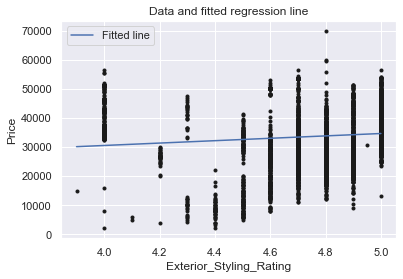

In [50]:
predictor = "Exterior_Styling_Rating"
outcome = "Price"
data = df1.copy()
results_ = results_Ex.copy()

# Plot the data
plt.scatter(data[predictor], data[outcome], color = "k", marker=".")

# Calculate the fitted values
a_hat = results_.loc["Intercept"]["coef"]
b_hat = results_.loc[predictor]["coef"]

x_domain = np.linspace(np.min(data[predictor]), np.max(data[predictor]), 10000)

fitted_values = a_hat + b_hat * x_domain

# Plot the fitted line
plt.plot(x_domain, fitted_values, label="Fitted line", color = "b")

# Add a legend and labels
plt.legend()
plt.ylabel("Price")
plt.xlabel("Exterior_Styling_Rating")

# Add a title and adjust the margins
plt.title("Data and fitted regression line")

# Show the plot
plt.show()

In [51]:
results_Ex

,coef,std err
Intercept,14043.815630,2458.142818
Exterior_Styling_Rating,4115.959896,517.373914


In [62]:
model = smf.ols('Price ~ Exterior_Styling_Rating + Interior_Design_Rating + Performance_Rating + Value_For_Money_Rating + Reliability_Rating + Consumer_Rating + Condition + avg_MPG', df1).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.577
Model:                            OLS   Adj. R-squared:                  0.576
Method:                 Least Squares   F-statistic:                     668.7
Date:                Sat, 15 Apr 2023   Prob (F-statistic):               0.00
Time:                        00:11:03   Log-Likelihood:                -45249.
No. Observations:                4426   AIC:                         9.052e+04
Df Residuals:                    4416   BIC:                         9.058e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept               -2

In [63]:
model.rsquared

0.5767679350131063

# Coefficient Interpretation

In [54]:
model = smf.ols('Price ~ Exterior_Styling_Rating + Consumer_Rating + Condition', df1)
results = model.fit()
print_coef_std_err(results)

,coef,std err
Intercept,18294.639257,2233.161869
Condition[T.New],6844.602081,512.502812
Condition[T.Used],-6228.562640,519.164050
Exterior_Styling_Rating,2575.975270,407.820872
Consumer_Rating,459.048280,234.618023


- Intercept: jika semua variabel independen bernilai 0, maka harga mobil akan memiliki nilai rata-rata sebesar 18,294.63 dollar.
- Condition_New: jika mobil baru, maka harga mobil akan meningkat sebesar 6,844.60 dollar dibandingkan dengan mobil bekas.
- Condition_Used: koefisien untuk variabel dummy ini negatif, yang menunjukkan bahwa jika mobil bekas, maka harga mobil akan turun sebesar 6,228.56 dollar dibandingkan dengan mobil baru.
- Exterior_Styling_Rating: untuk setiap peningkatan satu poin pada rating eksterior mobil, harga mobil akan meningkat sebesar 2,575.97 dollar.
- Consumer_Rating: untuk setiap peningkatan satu poin pada rating konsumen mobil, harga mobil akan meningkat sebesar 459.88 dollar.